In [498]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import preprocessing
from datetime import datetime

# A. 準備資料

In [4]:
all_beauty_path = 'data/All_Beauty.csv'
# all_beauty_path = 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv'
ratings = pd.read_csv(
    all_beauty_path,
    names=["asin", "reviewerID", "overall", "unixReviewTime"],
    dtype={"asin": np.str_, "reviewerID": np.str_, "overall": np.float32, "unixReviewTime": np.float64 }
)
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
ratings.head()

,asin,reviewerID,overall,unixReviewTime,DATE
0,0143026860,A1V6B6TNIC10QE,1.0,1.424304e+09,2015-02-19
1,0143026860,A2F5GHSXFQ0W6J,4.0,1.418861e+09,2014-12-18
2,0143026860,A1572GUYS7DGSR,4.0,1.407629e+09,2014-08-10
3,0143026860,A1PSGLFK1NSVO,5.0,1.362960e+09,2013-03-11
4,0143026860,A6IKXKZMTKGSC,5.0,1.324771e+09,2011-12-25


In [7]:
meta_all_beauty_path = 'data/meta_All_Beauty.json.gz'
# meta_all_beauty_path = 'http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz'
metadata = pd.read_json(
    meta_all_beauty_path,
    lines=True,
    compression="gzip"
)
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [9]:
print(metadata.columns)

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat',
       'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes'],
      dtype='object')


# B. 資料切分

In [6]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') &
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())


# C. 資料探索

## C. 資料探索 - 商品 (metadata) 的資料量

| 名稱          | 數量  | 佔比                  |
|---------------|-------|-----------------------|
| category      | 0     | 0%                    |
| tech1         | 10    | 0.030402529490453606% |
| tech2         | 0     | 0%                    |
| fit           | 0     | 0%                    |
| similar_item  | 1304  | 3.9644898455551503%   |
| also_view_len | 8132  | 24.723336981636873%   |
| also_buy_len  | 6597  | 20.056548704852244%   |
| feature       | 269   | 0.8178280432932019%   |
| details       | 32760 | 99.59868661072602%    |
| description   | 15119 | 45.96558433661681%    |
| rank          | 32452 | 98.66228870242004%    |


我們發現 tech1, tech2, fit, similar_item, also_view, also_buy, feature 有值的量有點少 (0~25%)，所以做為商品的分類不太合適。

其中，details 雖然大部分都有，但提供的資訊有：
```
Item Weight
Product Dimensions
ASIN
Batteries
Discontinued by manufacturer
Domestic Shipping
International Shipping
Item model number
Shipping Advisory
Shipping Weight
UPC
```
沒有很決定性的類分資訊。

最後，決定用 description 做為我主要的分類略策。


In [600]:
# helper
def print_amount(label, df):
    print('%s: %s (%s%%)' % (label, len(df), len(df)/len(metadata) * 100.0))


In [601]:
# category
print_amount('category', metadata[metadata['category'].str.len() > 0])

category: 0 (0.0%)


In [602]:
# tech1
print_amount('tech1', metadata[metadata['tech1'].str.len() > 0])

tech1: 10 (0.030402529490453606%)


In [603]:
# tech2: 沒有 tech2 資料
print_amount('tech2', metadata[metadata['tech2'].str.len() > 0])

tech2: 0 (0.0%)


In [604]:
# fit: 沒有 fit 資料
print_amount('fit', metadata[metadata['fit'].str.len() > 0])

fit: 0 (0.0%)


In [605]:
# similar_item
print_amount('similar_item', metadata[metadata['similar_item'].str.len() > 0])

similar_item: 1304 (3.9644898455551503%)


In [606]:
# also_view
metadata['also_view_len'] = metadata.apply(lambda row: len(row['also_view']), axis=1)
print_amount('also_view', metadata[metadata['also_view_len'] > 0])

also_view: 8132 (24.723336981636873%)


In [607]:
# also_buy
metadata['also_buy_len'] = metadata.apply(lambda row: len(row['also_buy']), axis=1)
print_amount('also_buy', metadata[metadata['also_buy_len'] > 0])

also_buy: 6597 (20.056548704852244%)


In [608]:
# 產品特色
metadata['feature_list_len'] = metadata.apply(lambda row: len(row['feature']), axis=1)
print_amount('feature', metadata[metadata['feature_list_len'] > 0])

# 結論
# 不能直接拿 feature 欄位

feature: 269 (0.8178280432932019%)


In [609]:
# details
metadata[['details']].head()
metadata['details_len'] = metadata.apply(lambda row: len(row['details'].items()), axis=1)
print_amount('details', metadata[metadata['details_len'] > 0])

metadata_details = [list(detail.items()) for detail in metadata['details'].tolist()]
metadata_details_keys = [[key for (key, value) in pairs] for pairs in metadata_details]
metadata_details_keys = list(np.concatenate(metadata_details_keys).flat)
metadata_details_keys = set(metadata_details_keys)
metadata_details_keys

# 結論
# 大部分的資料有都有 details，但 detail 中的欄位，用途看起來不大

details: 32760 (99.59868661072602%)


{'\n    Item Weight: \n    ',
 '\n    Product Dimensions: \n    ',
 'ASIN:',
 'ASIN: ',
 'Batteries',
 'Discontinued by manufacturer:',
 'Domestic Shipping: ',
 'International Shipping: ',
 'Item model number:',
 'Shipping Advisory:',
 'Shipping Weight:',
 'UPC:'}

In [610]:
# description
print_amount('description', metadata[metadata['description'].str.len() > 0])
metadata[['description']].head()

# 結論
# 有快一半的資料有 description，所以應該可以拿來用

description: 15119 (45.96558433661681%)


,description
0,[Loud 'N Clear Personal Sound Amplifier allows...
1,[No7 Lift & Luminate Triple Action Serum 50ml ...
2,[No7 Stay Perfect Foundation now stays perfect...
3,[]
4,[Lacto Calamine Skin Balance Daily Nourishing ...


In [611]:
# rank
def take_number(row):
    if type(row) is list and len(row) > 0:
        return str(row[0]).replace(',', '')
    else:
        return 0

metadata['rank_num_str'] = metadata['rank'].str.split().apply(lambda row: take_number(row))
print_amount('rank', metadata[metadata['rank_num_str'].str.len() > 0])

rank: 32452 (98.66228870242004%)


## C. 資料探索 - 使用者購買次數
我們順便統計一下：在訓練集的資料中，使用者購買次數，有 88% 的人買過一次。

In [612]:
user_bought = ratings_trainings.groupby('reviewerID').agg(bought_list=('asin', list)).reset_index()
user_bought['bought_list_len'] = user_bought.apply(lambda row: len(row['bought_list']), axis=1)
user_bought

,reviewerID,bought_list,bought_list_len
0,A0010876CNE3ILIM9HV0,[B01FHDYGQ8],1
1,A001170867ZBE9FORRQL,"[B01B18T01Y, B01FCW88D6]",2
2,A0028738FYF1SKPPC7B1,[B00TZ8XK1E],1
3,A0045356A23634W7RI4M,[B018H0EJI8],1
4,A006277084SDH2LTUV6X,[B01DKQAXC0],1
...,...,...,...
323484,AZZW8CF93X1TC,[B01HD23OJG],1
323485,AZZWNU4RB5BY1,[B01E5GSQOQ],1
323486,AZZXKG9AGRVGU,[B01DVW54I6],1
323487,AZZYW4YOE1B6E,[B003KWO3UI],1


In [613]:
total_user_len = len(user_bought['reviewerID'])
bought_distribution = user_bought.groupby('bought_list_len').agg(reviewer_ids=('reviewerID', list), reviewer_ids_len=('reviewerID', 'count'))
bought_distribution['percentage'] = bought_distribution.apply(lambda row: row['reviewer_ids_len']/total_user_len * 100, axis=1)
bought_distribution
# 結論：有 88% 的人買過一次

,reviewer_ids,reviewer_ids_len,percentage
bought_list_len,,,
1,"[A0010876CNE3ILIM9HV0, A0028738FYF1SKPPC7B1, A...",287267,88.802710
2,"[A001170867ZBE9FORRQL, A0137540IHMZM8Q3V1QD, A...",30111,9.308199
3,"[A101CAMZDHU1V9, A1046ICIMHENBN, A10658GHKIVJJ...",3697,1.142852
4,"[A100UD67AHFODS, A100WO06OQR8BQ, A104MYYMJJ3WV...",1017,0.314385
5,"[A10JB7YPWZGRF4, A10P0NAKKRYKTZ, A10Y59HW4O47N...",773,0.238957
6,"[A10ZJZNO4DAVB, A1118RD3AJD5KH, A11F87LHCF6KV2...",455,0.140654
7,"[A10M2MLE2R0L6K, A10ZBR6O8S8OCY, A13VVUDVNG1LS...",66,0.020403
8,"[A105A034ZG9EHO, A15T9G38F589KM, A17IS2KTMUBJ5...",35,0.010820
9,"[A1210QJT54O8T0, A16AXQ11SZA8SQ, A1B4SZX87THLC...",24,0.007419


# D. 內容過濾的推薦算法
## D. 內容過濾的推薦算法　－　Item representation
計算商品用 **「描述(description)」** 所表示的 tfidf 矩陣

In [614]:
# 把 description 接起來
metadata['description_join'] = metadata.apply(lambda row: ' '.join(row['description']), axis=1)
metadata['description_join']

0        Loud 'N Clear Personal Sound Amplifier allows ...
1        No7 Lift & Luminate Triple Action Serum 50ml b...
2        No7 Stay Perfect Foundation now stays perfect ...
3                                                         
4        Lacto Calamine Skin Balance Daily Nourishing L...
                               ...                        
32887                                                     
32888                                                     
32889                                                     
32890    Brand new and high quality<br> Enables fast vo...
32891                                                     
Name: description_join, Length: 32892, dtype: object

In [615]:
df = metadata.drop_duplicates('description_join')
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df['description_join'])

In [616]:
X = tfidf_matrix.toarray()
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [617]:
tf.get_feature_names_out()


array(['00', '000', '00000', ..., 'zytase', 'zzz', 'zzzrt'], dtype=object)

### D. 內容過濾的推薦算法　－ 1. Item representation　－　觀察分佈
以　`tfidf_matrix` 的 row 為向量，經過 TSNE 降至2維後觀察分佈。

一共做了兩張圖：
1. 以　`tfidf_matrix` 的 row 為向量
2. normalize向量後

結論是，特徵向量沒有很明顯的聚在一起，大部分都散打在一起。

/Users/eugenechen/.conda/envs/ac-python-test/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


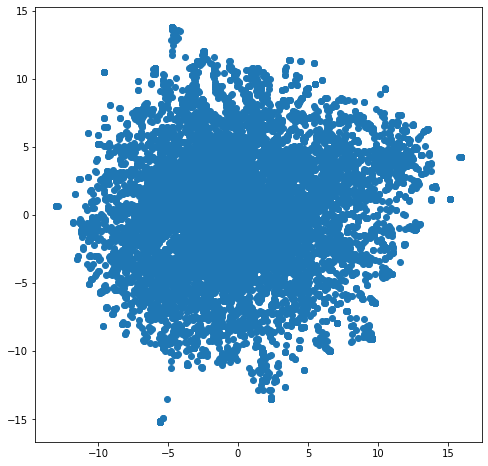

In [269]:
# Defining Model
model = TSNE(learning_rate=100)

# Fitting Model
transformed = model.fit_transform(X)

# Plotting 2d t-Sne
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.figure(figsize=(8, 8))
plt.scatter(x_axis, y_axis)
plt.show()

/Users/eugenechen/.conda/envs/ac-python-test/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


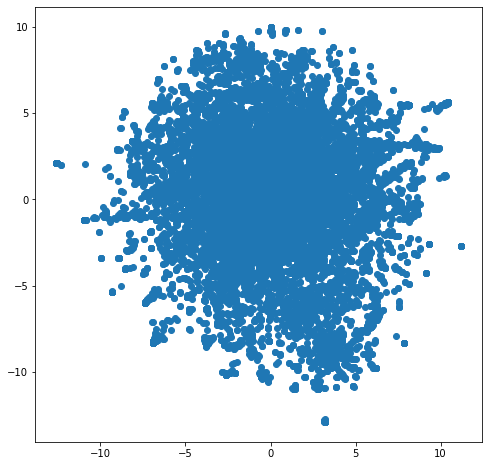

In [281]:
normal_X = preprocessing.normalize(X, axis=1)

normal_model = TSNE(learning_rate=100)
transformed = model.fit_transform(normal_X)
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.figure(figsize=(8, 8))
plt.scatter(x_axis, y_axis)
plt.show()


從上兩圖來看，特徵向量沒有很明顯的聚在一起，大部分都散打在一起。

## D. 內容過濾的推薦算法　－　2. Profiling Learning
計算使用者的購買/偏好行為

### D. 內容過濾的推薦算法　－　2. Profiling Learning　－ 計算商品間的相似程度
計算任兩筆商品之間的 cosine_similarity，我們先拿沒有 normalized 過的特徵向量

In [619]:
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_matrix


array([[1.        , 0.        , 0.02296188, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.10044222, ..., 0.        , 0.        ,
        0.        ],
       [0.02296188, 0.10044222, 1.        , ..., 0.        , 0.00903779,
        0.02544186],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00903779, ..., 0.        , 1.        ,
        0.02383864],
       [0.        , 0.        , 0.02544186, ..., 0.        , 0.02383864,
        1.        ]])

### D. 內容過濾的推薦算法　－　2. Profiling Learning　－ 推薦相似程度
利用 similarity_matrix 找出每個商品回傳 k 個最相近的商品。

In [622]:
# description_join -> 商品index 流水號
mapping = pd.Series(df.index, index = df['description_join'])
mapping

description_join
Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room.                                                                                                                                                                                                                                                                                                                                                                                                                                 0
No7 Lift & Luminate Triple Action Serum 50ml by Boots                                                                                                                                                                                                                                                                                                                    

In [623]:
def get_user_bought_list(ratings_df, user):
    return ratings_df[ratings_df['reviewerID'] == user]['asin'].tolist()

def recommend_item(item_input, k=2):
    """
    :param item_input: string, description_join
    :param k: 取出相似個數
    :return: 回傳 list
    """
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []


## D. 內容過濾的推薦算法　－　3. Recommendation Generation
每一個使用者所購買的商品，分別把跟這些商品相似的商品加入到最終的推薦清單。

In [624]:
def recommend_items(items, k):
    """
    :param items: item title list
    :param k:
    :return:
    """
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

## D. 內容過濾的推薦算法　－　4. 開始推薦

In [625]:
def recommender(training_data, users=[], k=10):
    """
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    """

    '''
    content-based
    '''
    ratings_trainings = training_data
    recommendations = {user: recommend_items(metadata[metadata['asin'].isin(get_user_bought_list(ratings_trainings,user))]['description_join'].tolist(), k) for user in users}
    return recommendations


ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['6546546450',
  '7178680776',
  '7250468162',
  '7367905066',
  '7414204790',
  '7535842801',
  '8279996397',
  '8637910351',
  '8867326759',
  '9197882747'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': [],
 'A174YOBOSW9WDN': 

## D. 內容過濾的推薦算法　－　5. 結果評估

In [626]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0

# E. 分析失敗結果
看來測試資料中，很多人的推薦清單都是空的。若對於沒的買過的人，使用相似商品的推薦，就會出現 cold start 的問題。

為了鑑別出目前 content-base 的好壞，我們先把"測試資料"分兩類的人：
1. 沒有買過的人 (在"訓練的資料中")
2. 有買過的人

```
所有測試的人 = 在訓練集中 + 不在訓練集中
584        = 38       + 546
```
因為大部分的人都不在訓練集中，這表示我們若使用推薦「買過商品中，推薦描述相似商品」的方法，應該都不會得到好的 recall 結果。

In [627]:
train_users= set(ratings_trainings['reviewerID'].tolist())
train_users
users_in_train = [user for user in users if user in train_users]
users_not_in_train = [user for user in users if user not in train_users]
print('所有測試的人 = 在訓練集中 + 不在訓練集中')
print('%s        = %s       + %s' % (len(users), len(users_in_train), len(users_not_in_train)))

所有測試的人 = 在訓練集中 + 不在訓練集中
584        = 38       + 546


In [628]:
# 調整成不依賴 ratings_testings
def evaluate_fix(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    all_count = sum([len(asin_list) for (user, asin_list) in ratings_testings_by_user.items()])
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / all_count
    return score

In [629]:
ratings_testings_by_user_in_train = {user: ratings_testings_by_user[user] for user in users_in_train if user in ratings_testings_by_user}
evaluate_fix(ratings_testings_by_user_in_train, recommender(ratings_trainings, users_in_train))

0.0

結論：若只算在訓練集資料的人，recall 也是 0

## E. 分析失敗結果 - 優化嘗試

### E. 分析失敗結果 - 優化嘗試 - 使用 normalize 過的 tfidf_matrix
使用 normalize 過的 tfidf_matrix

結論： recall 一樣是 0

In [630]:
normal_tfidf_matrix = preprocessing.normalize(tfidf_matrix, axis=1)

In [631]:
similarity_matrix_normalized = cosine_similarity(normal_tfidf_matrix)

In [632]:
def recommend_item_for_normalized(item_input, k=2):
    """
    :param item_input: string, description_join
    :param k: 取出相似個數
    :return: 回傳 list
    """
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix_normalized[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

def recommend_items_for_normalized(items, k):
    res = []
    for d in items:
        res.extend(recommend_item_for_normalized(d, k))
    return res

def recommender_for_normalized(training_data, users=[], k=10):
    ratings_trainings = training_data
    recommendations = {user: recommend_items_for_normalized(metadata[metadata['asin'].isin(get_user_bought_list(ratings_trainings,user))]['description_join'].tolist(), k) for user in users}
    return recommendations

recommender_list_for_normalized = recommender_for_normalized(ratings_trainings, users_in_train)
print('recall: ', evaluate_fix(ratings_testings_by_user_in_train, recommender_list_for_normalized))
recommender_list_for_normalized

recall:  0.0


{'A13JU88JAHN72I': ['6546546450',
  '7178680776',
  '7250468162',
  '7367905066',
  '7414204790',
  '7535842801',
  '8279996397',
  '8637910351',
  '8867326759',
  '9197882747'],
 'A16Y7V1CZCWKFV': [],
 'A19503XX7GU6J2': ['6546546450',
  '7178680776',
  '7250468162',
  '7367905066',
  '7414204790',
  '7535842801',
  '8279996397',
  '8637910351',
  '8867326759',
  '9197882747',
  '6546546450',
  '7178680776',
  '7250468162',
  '7367905066',
  '7414204790',
  '7535842801',
  '8279996397',
  '8637910351',
  '8867326759',
  '9197882747'],
 'A1EY751AUVO5NZ': ['6546546450',
  '7178680776',
  '7250468162',
  '7367905066',
  '7414204790',
  '7535842801',
  '8279996397',
  '8637910351',
  '8867326759',
  '9197882747'],
 'A1PR178735XC70': [],
 'A1SA3N793WT2LM': ['B000N5QWH2',
  'B01FUJNXMC',
  'B003XSINE6',
  'B00I547XB2',
  'B001233G4G',
  'B003PP0CPU',
  'B001MA2CGC',
  'B01BX1DRM2',
  'B01H2IIXJC',
  'B01FY36NUS',
  'B00HLXEXDO',
  'B000F8JKF8',
  'B00XLBSHN2',
  'B01G6HK13G',
  'B01CM3CCAI',

### E. 分析失敗結果 - 優化嘗試 - 在從相似清單選出 k 個是否對 recall 有影響力 (description)

當因為一次購買紀錄會有　10 個，二次就會有 20 個...。
為了增加 recall 我們試圖提高每次購買紀錄的 k，看 recall 有沒有提高？

> 注意：因為 recall 計算沒有考慮到 FP（使用者沒有買，在推薦的商品) ，所以從推薦相似商品清單再選出”精選 k”對 recall 是沒有幫助的。

> 因為不在訓練集的 users 太多了，會讓 recall 很可能會變 0。
> 因此，倘若我們計算users在訓練集的 recall 是 0，就可以推論出考慮完整的測試集的 users 也會是 0

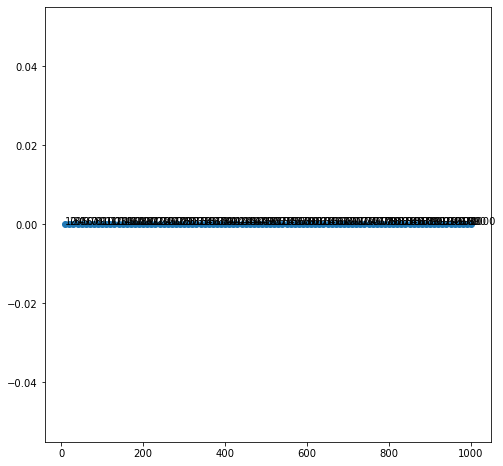

[[10, 0.0],
 [20, 0.0],
 [30, 0.0],
 [40, 0.0],
 [50, 0.0],
 [60, 0.0],
 [70, 0.0],
 [80, 0.0],
 [90, 0.0],
 [100, 0.0],
 [110, 0.0],
 [120, 0.0],
 [130, 0.0],
 [140, 0.0],
 [150, 0.0],
 [160, 0.0],
 [170, 0.0],
 [180, 0.0],
 [190, 0.0],
 [200, 0.0],
 [210, 0.0],
 [220, 0.0],
 [230, 0.0],
 [240, 0.0],
 [250, 0.0],
 [260, 0.0],
 [270, 0.0],
 [280, 0.0],
 [290, 0.0],
 [300, 0.0],
 [310, 0.0],
 [320, 0.0],
 [330, 0.0],
 [340, 0.0],
 [350, 0.0],
 [360, 0.0],
 [370, 0.0],
 [380, 0.0],
 [390, 0.0],
 [400, 0.0],
 [410, 0.0],
 [420, 0.0],
 [430, 0.0],
 [440, 0.0],
 [450, 0.0],
 [460, 0.0],
 [470, 0.0],
 [480, 0.0],
 [490, 0.0],
 [500, 0.0],
 [510, 0.0],
 [520, 0.0],
 [530, 0.0],
 [540, 0.0],
 [550, 0.0],
 [560, 0.0],
 [570, 0.0],
 [580, 0.0],
 [590, 0.0],
 [600, 0.0],
 [610, 0.0],
 [620, 0.0],
 [630, 0.0],
 [640, 0.0],
 [650, 0.0],
 [660, 0.0],
 [670, 0.0],
 [680, 0.0],
 [690, 0.0],
 [700, 0.0],
 [710, 0.0],
 [720, 0.0],
 [730, 0.0],
 [740, 0.0],
 [750, 0.0],
 [760, 0.0],
 [770, 0.0],
 [780, 0

In [633]:
points = []
for i in range(100):
    k = (i + 1) * 10
    ratings_by_user = recommender(ratings_trainings, users_in_train, k)
    recall = evaluate_fix(ratings_testings_by_user_in_train, ratings_by_user)
    points.append([k, recall])

plt.figure(figsize=(8, 8))
x_axis = np.array(points)[:, 0]
y_axis = np.array(points)[:, 1]
for [k, recall] in points:
    plt.text(k, recall, k)
plt.scatter(x_axis, y_axis)
plt.show()

points

# 結論，k 的提高，對 recall 沒有幫助

### E. 分析失敗結果 - 優化嘗試 - 在從相似清單選出 k 個是否對 recall 有影響力 (title)
若使用 title 做特徵向量，來做產品分類。

一樣我們提高選出的相似商品量（k　提高 ），觀察 recall，我們發現 k = 170 有提高一點

In [388]:
df = metadata.drop_duplicates('title')
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df['title'])
mapping_title = pd.Series(df.index, index = df['title'])
similarity_matrix_title = cosine_similarity(tfidf_matrix)
def recommend_item_for_title(item_input, k=2):
    """
    :param item_input: string, 商品名
    :param k: 取出相似個數
    :return: 回傳 list
    """
    try:
        item_index = mapping_title[item_input]
        similarity_score = list(enumerate(similarity_matrix_title[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []
def recommend_items_for_title(items, k):
    """
    :param items: item title list
    :param k:
    :return:
    """
    res = []
    for d in items:
        res.extend(recommend_item_for_title(d, k))
    return res
def recommender_title(training_data, users=[], k=10):
    ratings_trainings = training_data
    recommendations = {user: recommend_items_for_title(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['title'].tolist(), k) for user in users}
    return recommendations

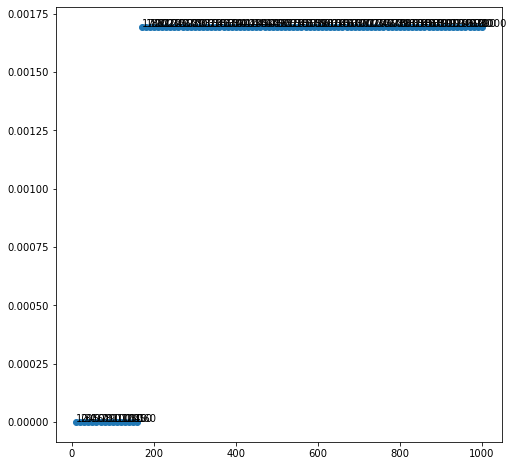

[[10, 0.0],
 [20, 0.0],
 [30, 0.0],
 [40, 0.0],
 [50, 0.0],
 [60, 0.0],
 [70, 0.0],
 [80, 0.0],
 [90, 0.0],
 [100, 0.0],
 [110, 0.0],
 [120, 0.0],
 [130, 0.0],
 [140, 0.0],
 [150, 0.0],
 [160, 0.0],
 [170, 0.001694915254237288],
 [180, 0.001694915254237288],
 [190, 0.001694915254237288],
 [200, 0.001694915254237288],
 [210, 0.001694915254237288],
 [220, 0.001694915254237288],
 [230, 0.001694915254237288],
 [240, 0.001694915254237288],
 [250, 0.001694915254237288],
 [260, 0.001694915254237288],
 [270, 0.001694915254237288],
 [280, 0.001694915254237288],
 [290, 0.001694915254237288],
 [300, 0.001694915254237288],
 [310, 0.001694915254237288],
 [320, 0.001694915254237288],
 [330, 0.001694915254237288],
 [340, 0.001694915254237288],
 [350, 0.001694915254237288],
 [360, 0.001694915254237288],
 [370, 0.001694915254237288],
 [380, 0.001694915254237288],
 [390, 0.001694915254237288],
 [400, 0.001694915254237288],
 [410, 0.001694915254237288],
 [420, 0.001694915254237288],
 [430, 0.001694915254

In [391]:
points = []
for i in range(100):
    k = (i + 1) * 10
    ratings_by_user = recommender_title(ratings_trainings, users_in_train, k)
    # recall = evaluate_fix(ratings_testings_by_user_in_train, ratings_by_user)
    recall = evaluate(ratings_testings_by_user, ratings_by_user)
    points.append([k, recall])

plt.figure(figsize=(8, 8))
x_axis = np.array(points)[:, 0]
y_axis = np.array(points)[:, 1]
for [k, recall] in points:
    plt.text(k, recall, k)
plt.scatter(x_axis, y_axis)
plt.show()

points

### E. 分析失敗結果 - 優化嘗試 - 結構化資料
從非結構化資料的 title/description 都得不到好的結果，我們轉向結構化資料。

特徵向量：(rank, 最近一次的評論的新鮮度)，這裡我們將 ：
* `rank` 的值normalize 到 0~1 之間
* `最近一次的評論的新鮮度` 的值normalize 到 0~1 之間， 0 表示越舊的資料，1 表示越新的資料

理想上，我希望依照「高評分和越近的評論」分類


In [634]:
# rank
metadata['rank_num'] = metadata['rank'].str.split()
def take_number(row):
    if type(row['rank_num']) is list and len(row['rank_num']) > 0:
        return str(row['rank_num'][0])
    else:
        return 0
metadata['rank_num'] = metadata.apply(lambda row: take_number(row), axis=1)
metadata['rank_num'] = pd.to_numeric(metadata['rank_num'].str.replace(',', ''))

df = metadata['rank_num']
metadata['rank_norm'] =(df-df.min())/(df.max()-df.min())
metadata['rank_norm']

0        0.307721
1        0.091401
2        0.100181
3        0.195848
4        0.007086
           ...   
32887    0.224652
32888    0.171705
32889    0.021716
32890    0.101121
32891    0.050065
Name: rank_norm, Length: 32892, dtype: float64

In [637]:
# 最近一次被評論
popular_metadata = metadata.merge(ratings_trainings, left_on='asin', right_on='asin')[['asin', 'DATE']]
popular_metadata = popular_metadata.groupby(by='asin').agg(date_list=('DATE', list)).reset_index()

def last_date(row):
    if type(row['date_list']) is list and len(row['date_list']) > 0:
        return max(row['date_list'])
    else:
        return datetime(2000, 1, 10, 10, 10)
popular_metadata['last'] = popular_metadata.apply(lambda row: last_date(row), axis=1)
popular_metadata

def inv_dis(row):
    return 1/ (datetime.now().timestamp() - row['last'].timestamp())
popular_metadata['inv_dis'] = popular_metadata.apply(lambda row: inv_dis(row), axis=1)

df = popular_metadata['inv_dis']
popular_metadata['dis_score_norm']=(df-df.min())/(df.max()-df.min())
popular_metadata

,asin,date_list,last,inv_dis,dis_score_norm
0,6546546450,"[2013-08-13 00:00:00, 2009-01-29 00:00:00]",2013-08-13,3.776758e-09,0.279939
1,7178680776,[2017-10-06 00:00:00],2017-10-06,7.469300e-09,0.745923
2,7250468162,[2017-08-26 00:00:00],2017-08-26,7.276762e-09,0.721626
3,7367905066,[2017-04-12 00:00:00],2017-04-12,6.703574e-09,0.649292
4,7414204790,"[2016-03-10 00:00:00, 2015-09-01 00:00:00, 201...",2018-03-02,8.252149e-09,0.844716
...,...,...,...,...,...
32477,B01HIWLLUK,[2016-09-24 00:00:00],2016-09-24,6.007660e-09,0.561470
32478,B01HJ1K3YK,[2017-04-21 00:00:00],2017-04-21,6.738701e-09,0.653724
32479,B01HJ84SGM,"[2018-03-23 00:00:00, 2017-10-03 00:00:00, 201...",2018-03-23,8.377584e-09,0.860545
32480,B01HJASD20,[2016-08-31 00:00:00],2016-08-31,5.933741e-09,0.552142


In [643]:
# 合併成 (rank, 最近一次的評論的新鮮度)
feature_df = popular_metadata.merge(metadata, how='inner', left_on='asin', right_on='asin')[['asin', 'rank_norm', 'dis_score_norm']]

def vec_len(row):
    return np.linalg.norm([row['rank_norm'], row['dis_score_norm']])
feature_df['feature_vec_len'] = feature_df.apply(lambda row: vec_len(row), axis=1)


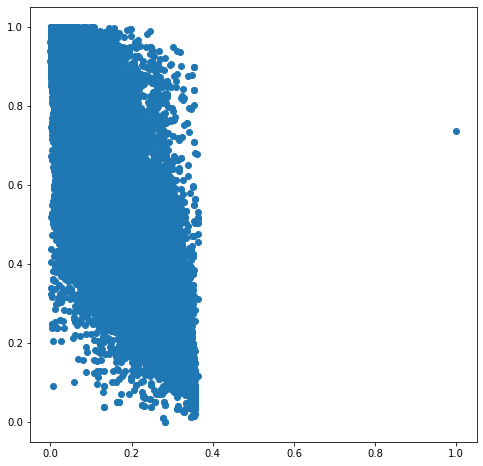

In [644]:
# 觀察一下　(rank, 最近一次的評論的新鮮度)的分佈
X = np.array(feature_df[['rank_norm', 'dis_score_norm']])
plt.figure(figsize=(8, 8))
x_axis = X[:, 0]
y_axis = X[:, 1]
plt.scatter(x_axis, y_axis)
plt.show()

In [646]:
# 去除不太好的資料
# 1. 去除向量長度為 0 的
# 2. 去除 rank_norm = 1，這個單點太突
feature_df = feature_df[feature_df['feature_vec_len'] > 0]
feature_df = feature_df[feature_df['rank_norm'] < 0.9]
feature_df


,asin,rank_norm,dis_score_norm,feature_vec_len
0,6546546450,0.307721,0.279939,0.416002
1,7178680776,0.091401,0.745923,0.751502
2,7250468162,0.100181,0.721626,0.728546
3,7367905066,0.195848,0.649292,0.678186
4,7414204790,0.007086,0.844716,0.844745
...,...,...,...,...
32881,B01HIWLLUK,0.224652,0.561470,0.604746
32882,B01HJ1K3YK,0.171705,0.653724,0.675898
32883,B01HJ84SGM,0.021716,0.860545,0.860819
32884,B01HJASD20,0.101121,0.552142,0.561325


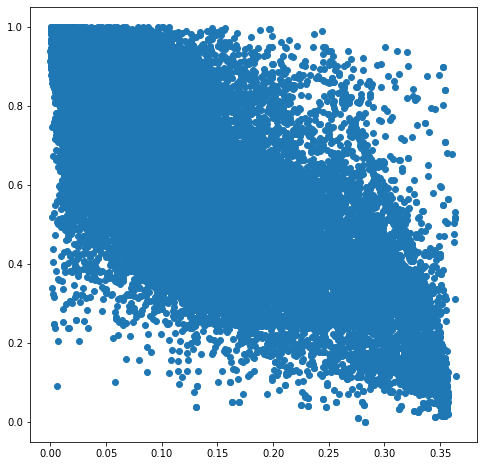

In [647]:
# 觀察一下　(rank, 最近一次的評論的新鮮度)的分佈
X = np.array(feature_df[['rank_norm', 'dis_score_norm']])
plt.figure(figsize=(8, 8))
x_axis = X[:, 0]
y_axis = X[:, 1]
plt.scatter(x_axis, y_axis)
plt.show()

In [648]:
mapping_asin_index = {}
i = 0
for asin in feature_df['asin'].tolist():
    mapping_asin_index[asin] = i
    i += 1

In [649]:
similarity_matrix = cosine_similarity(X)

In [650]:
def recommend_item_for_feature(asin_input, k=2):
    try:
        item_index = mapping_asin_index[asin_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (feature_df['asin'].iloc[item_indices].tolist())
    except:
        return []

def recommend_items_for_feature(items, k):
    res = []
    for d in items:
        res.extend(recommend_item_for_feature(d, k))
    return res

def recommender_for_feature(training_data, users=[], k=10):
    ratings_trainings = training_data
    recommendations = {user: recommend_items_for_feature(metadata[metadata['asin'].isin(get_user_bought_list(ratings_trainings, user))]['asin'].tolist(), k) for user in users}
    return recommendations

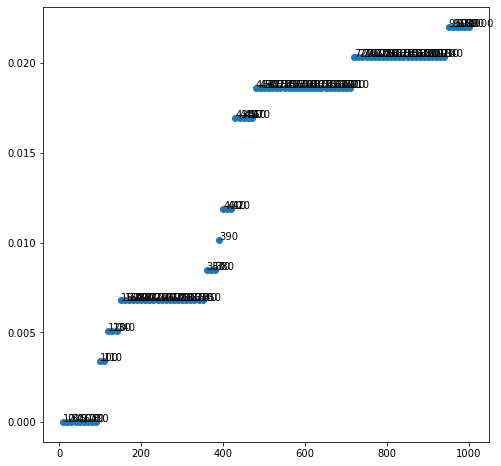

[[10, 0.0],
 [20, 0.0],
 [30, 0.0],
 [40, 0.0],
 [50, 0.0],
 [60, 0.0],
 [70, 0.0],
 [80, 0.0],
 [90, 0.0],
 [100, 0.003389830508474576],
 [110, 0.003389830508474576],
 [120, 0.005084745762711864],
 [130, 0.005084745762711864],
 [140, 0.005084745762711864],
 [150, 0.006779661016949152],
 [160, 0.006779661016949152],
 [170, 0.006779661016949152],
 [180, 0.006779661016949152],
 [190, 0.006779661016949152],
 [200, 0.006779661016949152],
 [210, 0.006779661016949152],
 [220, 0.006779661016949152],
 [230, 0.006779661016949152],
 [240, 0.006779661016949152],
 [250, 0.006779661016949152],
 [260, 0.006779661016949152],
 [270, 0.006779661016949152],
 [280, 0.006779661016949152],
 [290, 0.006779661016949152],
 [300, 0.006779661016949152],
 [310, 0.006779661016949152],
 [320, 0.006779661016949152],
 [330, 0.006779661016949152],
 [340, 0.006779661016949152],
 [350, 0.006779661016949152],
 [360, 0.00847457627118644],
 [370, 0.00847457627118644],
 [380, 0.00847457627118644],
 [390, 0.0101694915254237

In [569]:
points = []
for i in range(100):
    k = (i + 1) * 10
    ratings_by_user = recommender_for_feature(ratings_trainings, users_in_train, k)
    # recall = evaluate_fix(ratings_testings_by_user_in_train, ratings_by_user)
    recall = evaluate(ratings_testings_by_user, ratings_by_user)
    points.append([k, recall])

plt.figure(figsize=(8, 8))
x_axis = np.array(points)[:, 0]
y_axis = np.array(points)[:, 1]
for [k, recall] in points:
    plt.text(k, recall, k)
plt.scatter(x_axis, y_axis)
plt.show()

points

k 在 100 以上時，recall 開始 > 0。

結論：在拿結構化 feature (rank, 最近一次的評論的新鮮度) 比單純用非結構化（title 和 description）還好

### E. 分析失敗結果 - 優化嘗試 - 混合 content-base + rule-base
1. 有購買記錄的人：用 content-base， 拿”(rank, 最近一次的評論的新鮮度)” 當特徵向量
2. 沒有購買記錄的人：用 rule-base,　排序 ”(rank, 最近一次的評論的新鮮度)” 向量長度，選 k 個

In [651]:
global_goods_list = feature_df.sort_values('feature_vec_len', ascending=False)['asin'].tolist()

def recommender_for_feature_fix(training_data, users=[], k=10):
    ratings_trainings = training_data
    recommendations = {}
    for user in users:
        user_bought_list = get_user_bought_list(ratings_trainings, user)
        if(len(user_bought_list) > 0):
            # content-base
            recommendations[user] = recommend_items_for_feature(metadata[metadata['asin'].isin(user_bought_list)]['asin'].tolist(), k)
        else:
            # rule-base
            recommendations[user] = global_goods_list[:k]
    return recommendations

In [652]:
recommender_for_feature_fix(ratings_trainings, users, 10)

{'A100XQFWKQ30O2': ['B01GR1XPU2',
  'B00N6FCRYS',
  'B015SP1Y10',
  'B00IAYT33S',
  'B00AN382P4',
  'B01DZQKQLS',
  'B01DLR9IDI',
  'B01FIPS9WW',
  'B014I56NSU',
  'B017MXJ6CK'],
 'A103T1QOGFCSEH': ['B01GR1XPU2',
  'B00N6FCRYS',
  'B015SP1Y10',
  'B00IAYT33S',
  'B00AN382P4',
  'B01DZQKQLS',
  'B01DLR9IDI',
  'B01FIPS9WW',
  'B014I56NSU',
  'B017MXJ6CK'],
 'A106UKKSJ2KXPF': ['B01GR1XPU2',
  'B00N6FCRYS',
  'B015SP1Y10',
  'B00IAYT33S',
  'B00AN382P4',
  'B01DZQKQLS',
  'B01DLR9IDI',
  'B01FIPS9WW',
  'B014I56NSU',
  'B017MXJ6CK'],
 'A10A7GV4D5A11V': ['B01GR1XPU2',
  'B00N6FCRYS',
  'B015SP1Y10',
  'B00IAYT33S',
  'B00AN382P4',
  'B01DZQKQLS',
  'B01DLR9IDI',
  'B01FIPS9WW',
  'B014I56NSU',
  'B017MXJ6CK'],
 'A1119JJ37ZLB8R': ['B01GR1XPU2',
  'B00N6FCRYS',
  'B015SP1Y10',
  'B00IAYT33S',
  'B00AN382P4',
  'B01DZQKQLS',
  'B01DLR9IDI',
  'B01FIPS9WW',
  'B014I56NSU',
  'B017MXJ6CK'],
 'A113UOOLBSZN52': ['B01GR1XPU2',
  'B00N6FCRYS',
  'B015SP1Y10',
  'B00IAYT33S',
  'B00AN382P4',
  'B01D

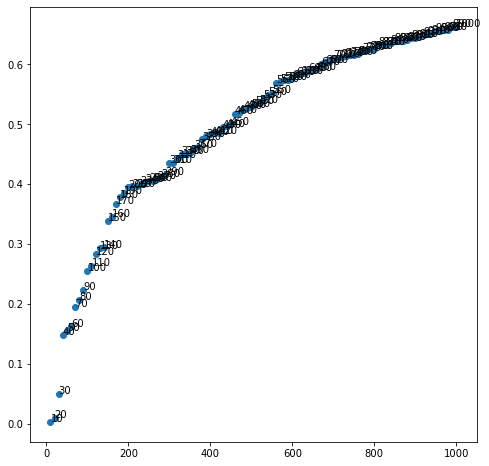

[[10, 0.003389830508474576],
 [20, 0.010169491525423728],
 [30, 0.05084745762711865],
 [40, 0.14915254237288136],
 [50, 0.15593220338983052],
 [60, 0.16271186440677965],
 [70, 0.19491525423728814],
 [80, 0.20677966101694914],
 [90, 0.22372881355932203],
 [100, 0.2559322033898305],
 [110, 0.26440677966101694],
 [120, 0.2830508474576271],
 [130, 0.29322033898305083],
 [140, 0.29491525423728815],
 [150, 0.3389830508474576],
 [160, 0.34576271186440677],
 [170, 0.3677966101694915],
 [180, 0.37796610169491524],
 [190, 0.3847457627118644],
 [200, 0.3949152542372881],
 [210, 0.39661016949152544],
 [220, 0.39661016949152544],
 [230, 0.4],
 [240, 0.4033898305084746],
 [250, 0.40508474576271186],
 [260, 0.40508474576271186],
 [270, 0.40847457627118644],
 [280, 0.411864406779661],
 [290, 0.4152542372881356],
 [300, 0.43559322033898307],
 [310, 0.43559322033898307],
 [320, 0.4440677966101695],
 [330, 0.45084745762711864],
 [340, 0.45084745762711864],
 [350, 0.45254237288135596],
 [360, 0.4610169491

In [582]:
points = []
for i in range(100):
    k = (i + 1) * 10
    ratings_by_user = recommender_for_feature_fix(ratings_trainings, users, k)
    recall = evaluate(ratings_testings_by_user, ratings_by_user)
    points.append([k, recall])

plt.figure(figsize=(8, 8))
x_axis = np.array(points)[:, 0]
y_axis = np.array(points)[:, 1]
for [k, recall] in points:
    plt.text(k, recall, k)
plt.scatter(x_axis, y_axis)
plt.show()

points

結論：從上圖看的出來，對於沒有購買記錄的人來說，用 rule-base 改善 recall 是必要的
